# Google Sources and its Effects on Votes

In this report, our big question will be: did the way people interact with our campaign materials influence how they voted? Specifically, was there a correlation between when we put efforts into marketing, and how citizens voted?

In [10]:
import pandas as pd
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [16]:
bigdf = pd.read_csv("data/source_medium_ganalytics.csv")
len(bigdf.index)

1001

In [17]:
bigdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   City                                1000 non-null   object 
 1   Source / Medium                     1000 non-null   object 
 2   Users                               1001 non-null   int64  
 3   New Users                           1001 non-null   int64  
 4   Sessions                            1001 non-null   int64  
 5   Bounce Rate                         1001 non-null   object 
 6   Pages / Session                     1001 non-null   float64
 7   Avg. Session Duration               1001 non-null   float64
 8   Donations (Goal 1 Conversion Rate)  1001 non-null   object 
 9   Donations (Goal 1 Completions)      1001 non-null   int64  
 10  Donations (Goal 1 Value)            1001 non-null   float64
 11  Source                              1000 no

Our DataFrame here essentially divides Impressions into two categories: the city in which it came from, and the source/medium it came from. For example, we would be examining Google searches from Woodside compared to Google searches from Stanford, as well as YouTube searches from Stanford.

In [18]:
cities = ['Woodside', 'Stanford', 'San Gregorio', 'Portola Valley', 'Pescadero', 'Palo Alto',
          'Pacifica', 'Menlo Park', 'Moss Beach', 'Montara', 'Monte Sereno', 'Loma Mar', 
          'Ladera' 'Los Gatos', 'Los Altos', 'Los Altos Hills', 'La Honda', 'Half Moon Bay',
          'El Granada', 'Campbell', 'Atherton', 'San Jose']
bigdf = bigdf[bigdf['City'].isin(cities)]

Since only cities in the cities list are able to vote, we will focus only on these geographic areas

In [19]:
len(bigdf.index)

141

In [20]:
sources = pd.unique(bigdf['Source'])
print(sources)

['cpc' 'organic' 'none' 'referral' 'txt' 'email']


In [45]:
cpcdf = bigdf[bigdf['Source']=='cpc']
orgdf = bigdf[bigdf['Source']=='organic']
refdf = bigdf[bigdf['Source']=='referral']
txtdf = bigdf[bigdf['Source']=='txt']
emdf = bigdf[bigdf['Source']=='email']
#dfs = [cpcdf, orgdf, refdf, txtdf, emdf]

We then split the dataframe into each source, so that we can examine each source by itself.
Afterwards, we create a new metric dubbed Impressions/Voter, so that we can control for different population sizes.

cpc
Pearsonr correlation for x,y = 0.409


organic
Pearsonr correlation for x,y = 0.451


referral
Pearsonr correlation for x,y = 0.335


txt
ONLY ONE DATA POINT.


email
ONLY ONE DATA POINT.




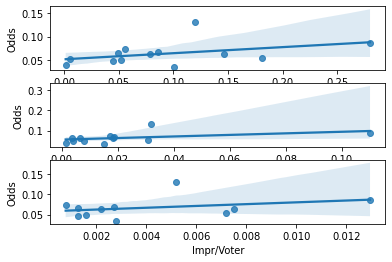

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
#create the plot

dfs = {'cpc': [cpcdf, ax1], 
       'organic': [orgdf, ax2],
       'referral': [refdf, ax3], 
       'txt': [txtdf], 
       'email': [emdf]}
votedf = pd.read_csv("data/fullcity_votes.csv")
for key, value in dfs.items():
    df = value[0]
    print(key)
    df = df.groupby("City").sum()
    #group by city
    
    
    df = pd.merge(left = df, right = votedf, on = ['City'])
    def odds(row):
        return row['Percentage']/(1-row['Percentage'])
    def ratio(row):
        return row['Users']/row['Total']
    df['Odds'] = df.apply(lambda row: odds(row), axis=1)
    df['Impr/Voter'] = df.apply(lambda row: ratio(row), axis=1)
    #calculate ratios based on populations, as well as transform percentage to odds
    #not much difference between percentage and odds
    
    df= df[(np.abs(st.zscore(df['Impr/Voter'])) < 3)]
    #get rid of outlier

    x = df['Impr/Voter'].to_numpy()
    y = df['Percentage'].to_numpy()
    if(x.size<2 or y.size<2):
        print("ONLY ONE DATA POINT.")
    else:
        pr = st.pearsonr(x, y)
        print(f'Pearsonr correlation for x,y = {pr[0]:5.3f}')
        sns.regplot(x = "Impr/Voter", y = "Odds", data = df, ax = value[1])
        
    #calculate correlation and plot
    print('\n')

    

In [44]:
plt.show()

Here, we can see that there is some correlation between how each source influences the odds, of winning, with organic boasting the highest score at 0.451. This does make sense, since someone who researches about a candidate organically would be more likely to vote for someone who has no interest and is forced to ingest campaign materials.

There is also an outlier in all 3 graphs, so we will do some investigation on where that outlier is.

In [56]:
df = dfs['organic'][0]
df = df.groupby("City").sum()
df = pd.merge(left = df, right = votedf, on = ['City'])
def odds(row):
    return row['Percentage']/(1-row['Percentage'])
def ratio(row):
    return row['Users']/row['Total']
df['Odds'] = df.apply(lambda row: odds(row), axis=1)
df['Impr/Voter'] = df.apply(lambda row: ratio(row), axis=1)
df= df[(np.abs(st.zscore(df['Impr/Voter'])) >= 3)]
df.head()

,City,Users,New Users,Sessions,Pages / Session,Avg. Session Duration,Donations (Goal 1 Completions),Donations (Goal 1 Value),BENJAMIN THOMAS SOLOMON,JOHN KARL FREDRICH,...,AJWANG RADING,RISHI KUMAR,ANNA G. ESHOO,PETER OHTAKI,GREG LIN TANAKA,Unnamed: 9,Total,Percentage,Odds,Impr/Voter
10,Stanford,136,127,146,3.68,127.75,16,0.0,3,1,...,5,16,60,16,5,NaN,112,0.044643,0.046729,1.214286


found it, it's stanford. probably because of weird precinct data + population data + voter registration data; tis been a common problem.